In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cellij
import numpy as np
import matplotlib.pyplot as plt

/Users/tim.treis/anaconda3/envs/spatialdata/envs/cellij/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mdata = cellij._data.Importer().load_CLL()
mdata["mrna"]

AnnData object with n_obs × n_vars = 136 × 5000

In [4]:
model = cellij.models.MOFA(n_factors=50)
model.add_data(data=mdata, na_strategy="knn_by_obs")

In [5]:
model.fit(likelihood="Normal",  epochs=30)

Epoch      0:     6584674.19 	 | 
Training finished.


In [6]:
model.get_w(views=["mrna", "drugs"])

{'mrna': array([[-0.02881576, -0.00589512, -0.00260387, ..., -0.02790998,
         -0.00331449,  0.03863374],
        [-0.0331322 ,  0.03614611,  0.03657613, ..., -0.01238973,
         -0.02103579,  0.02482222],
        [ 0.05101193, -0.06429015, -0.04746724, ...,  0.03954844,
          0.01759344, -0.01365871],
        ...,
        [ 0.00270932,  0.05945447,  0.03579368, ...,  0.03623813,
          0.02114286,  0.03046949],
        [-0.02680855, -0.04633483,  0.00912413, ..., -0.01483516,
          0.00743508, -0.01822462],
        [ 0.01853451,  0.04949849,  0.0121878 , ...,  0.01586927,
          0.01977735,  0.03026591]], dtype=float32),
 'drugs': array([[-0.0044437 , -0.00991912,  0.00545519, ...,  0.00104216,
         -0.0180489 ,  0.01106591],
        [ 0.00696381, -0.00963437,  0.02273866, ..., -0.00885264,
          0.00109065,  0.01904942],
        [ 0.00308375,  0.0113874 , -0.01511038, ...,  0.03195094,
         -0.02975564,  0.0220839 ],
        ...,
        [ 0.01221479, 

In [7]:
model.save("mofa.pkl")

In [8]:
mofa = cellij.utils.load_model("mofa.pkl")

<AxesSubplot:>

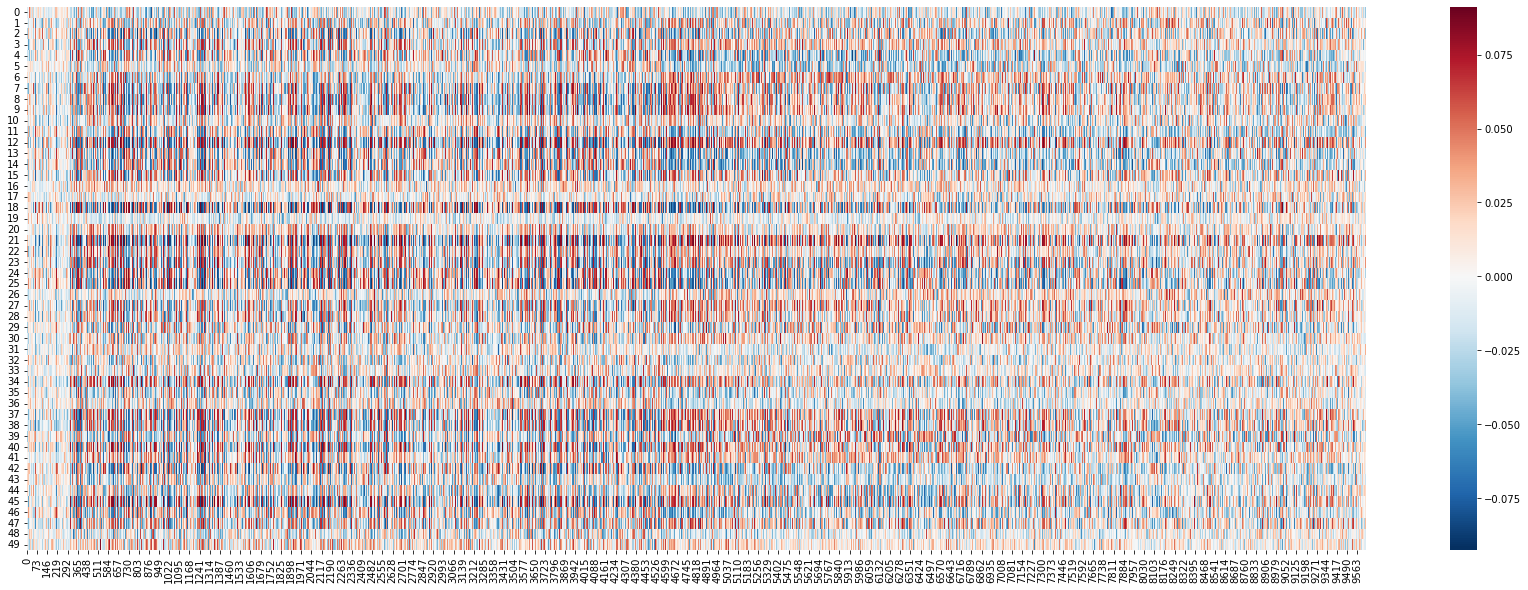

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
sns.heatmap(mofa.get_w(format="numpy"), center=0, cmap='RdBu_r')

torch.Size([50, 9627]) torch.Size([50, 9627])


<AxesSubplot:>

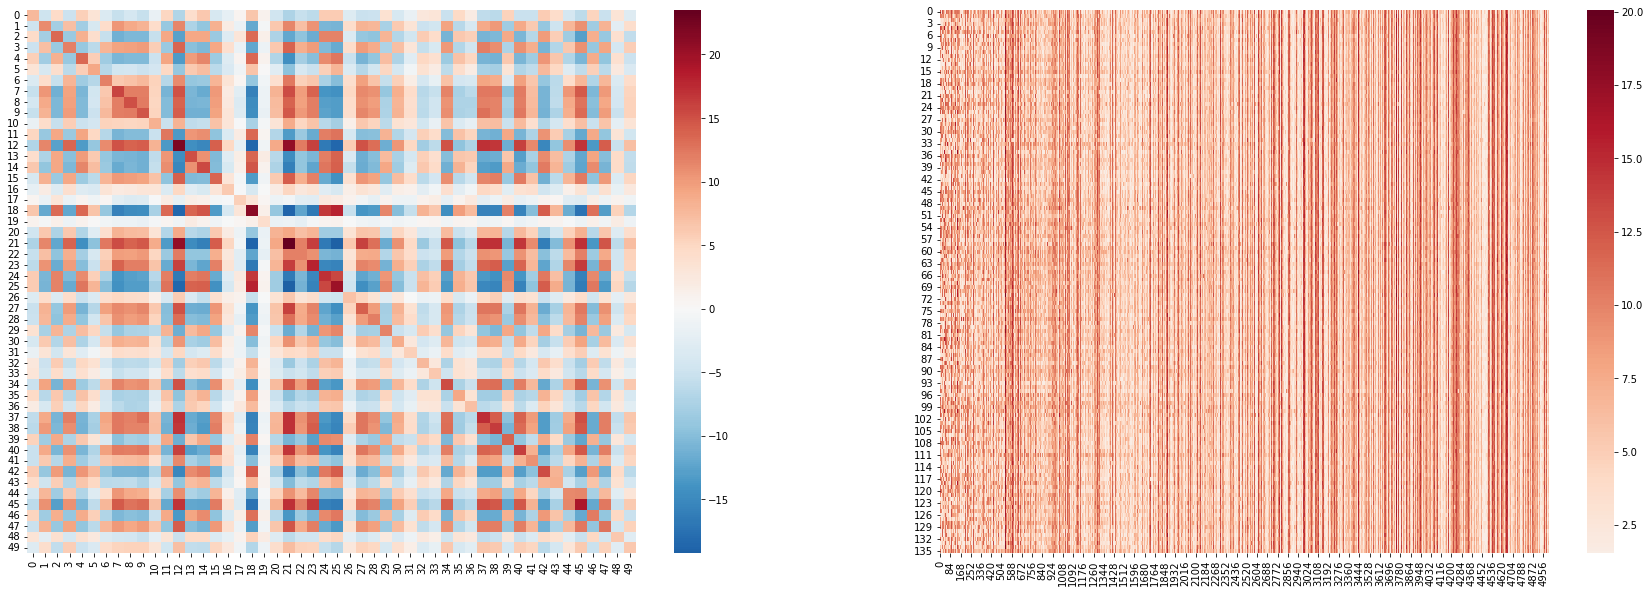

In [11]:
w = model.get_w()
z = model.get_z()

print(w.shape, z.shape)

xhat = np.matmul(z,w.T)

fig, ax = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(xhat, center=0, cmap='RdBu_r', ax=ax[0])
sns.heatmap(mdata["mrna"].X, center=0, cmap='RdBu_r', ax=ax[1])